In [1]:
from datetime import datetime, timedelta
import json
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm.notebook import tqdm



In [3]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.utcnow().replace(tzinfo=pytz.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = True

In [4]:
if DEV:
    RUN_DATE = '2021-02-02'
else:
    RUN_DATE = str(NOW.date())
RUN_DATE

'2021-02-02'

In [5]:
gist_file = open(f'{DATA_DIR}/gist_stopwords.txt', 'r')
try:
    content = gist_file.read()
    stopwords = content.split(",")
finally:
    gist_file.close()

In [6]:
stopwords = stopwords + ['from', 'subject', 're', 'edu', 'use',
    'abov', 'afterward', 'alon', 'alreadi', 'alway', 
    'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam',
    'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 
    'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 
    'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 
    'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 
    'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 
    'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 
    'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 
    'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc',
    'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv',
    'anywh', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh',
    'lol', 'nice', 'yeah', 'cool', 'dont', 'ill', 'wow', 'people', 
    'time',  'good', '0','1', '2', '3', 'isnt', 'things', 'thing', 
    'lot', 'doesnt', 'ive', 'work', 'hahahahaha', 'hahahaha', 'years', 
    '', 'true', '_', '_ _', '_ _ _', 'awesome', 'shit', 'guy', 'itll',
    'they\'ll',' theyve', 'https', 'pretty', 'didnt', 'abl', 'accord', 
    'actual', 'affect', 'announc', 'anybodi', 'anymor', 'appar', 
    'appreci', 'appropri', 'approxim', 'aris', 'articl', 'asid',
    'associ', 'avail', 'awesom', 'believ', 'briefli', 'caus', 'chang', 
    'clear', 'concern', 'consequ', 'consid', 'correspond', 'cours', 
    'current', 'definit', 'despit', 'differ', 'doe', 'downward', 
    'eighti', 'entir', 'especi', 'everybodi', 'exact', 'exampl', 
    'fifi', 'follow', 'furthermor', 'goe', 'greet', 'happen', 
    'hard', 'hope', "i'v", 'ignor', 'immedi', 'import', 'indic', 
    'inform', 'invent', 'larg', 'late', 'littl', 'main', 'mayb', 
    'meantim', 'mere', 'necessari', 'necessarili', 'nineti', 'normal', 
    'note', 'obvious', 'omit', 'outsid', 'overal', 'owe', 'peopl', 
    'place', 'poor', 'possibl', 'potenti', 'predomin', 'presum', 
    'pretti', 'previous', 'primarili', 'probabl', 'prompt', 'provid', 
    'quick', 'quit', 'readili', 'realli', 'reason', 'regard', 'relat', 
    'respect', 'result', 'selv', 'sensibl', "should'v", 'signific',
    'slight', 'somebodi', 'sorri', 'specif', 'specifi', 'strong',
    'substanti', 'success', 'suffici', 'tend', "that'v", "there'l",
    "there'v", 'therer', "they'r", "they'v", 'theyr', 'theyv', 'tri', 
    'truli', 'unfortun', 'unlik', 'usual', 'valu', 'volumtyp', "we'r",
    "we'v", 'welcom', 'whomev', 'wide', 'word', 'year', "you'r", "you'v",
    'ari', 'cour', 'signif', 'youll', 'youv', 'point', 'stuff',
    'joke', 'yup', 'great', 'fun', 'issue', 'stuff', 'point', 
    'feel', 'crap', 'fucking', 'fuck', 'dude', 'damn', 'suck',
    'lmao', 'stupid', 'haha', 'lol', 'nice', 'yeah', 'cool',  
    'didnt', 'youll', 'youv', 'big', 'yep', 'bot', 'yikes',
    'ya', 'tho', 'jesus', 'totally', 'chill', 'god', 'amazing',
    'nep', 'remindme', 'holy', 'as', 'wanna', 'ftw', 'enjoy',
    'gotta', 'crazy', 'die', 'small', 'hey', 'ban', 'bro',
    'guess', 'kid', 'bad', 'long', 'interesting', 'man',
    'wrong', 'kid', 'easy', 'difficult', 'upvote', 'like',
    'funny', 'friend', 'literally', 'hate', 'free', 'sucks',
    'dont', 'ill', 'https',]

In [7]:
len(stopwords)

1491

In [8]:
# stopwords

In [9]:
plt.style.use("ggplot")
plt.usetex = True

### Read reddit comments

In [35]:
comments_df = pd.read_json(
    f'{DATA_DIR}/reddit_comments_{RUN_DATE}.jsonl',
    orient='records',
    lines=True)

In [36]:
list(comments_df.columns)

['id',
 'author',
 'num_comments',
 'parent_id',
 'score',
 'author_fullname',
 'subreddit_id',
 'body',
 'link_title',
 'name',
 'downs',
 'is_submitter',
 'link_author',
 'subreddit',
 'link_url',
 'quarantine',
 'ups',
 'edited_at',
 'created_at',
 'sha_id',
 'inserted_at']

In [37]:
comments_df

,id,author,num_comments,parent_id,score,author_fullname,subreddit_id,body,link_title,name,...,is_submitter,link_author,subreddit,link_url,quarantine,ups,edited_at,created_at,sha_id,inserted_at
0,gc0q70n,baconialis,58,t1_gbzqzam,-1,t2_4av7n0ta,t5_2rzmn,Yet another reason to place your build logic i...,Building a new Jenkins pipeline,t1_gc0q70n,...,False,ilshots,devops,https://www.reddit.com/r/devops/comments/jsfx2...,False,-1,2020-11-12 06:53:40,2020-11-12 06:53:40,51be2aca197ce277b5d53c55f7590747a547da483d50e8...,2020-11-20 00:30:51.003
1,gc0r2vs,gutigen,35,t1_gbzjrkz,1,t2_9s3ua,t5_2rzmn,This thread is about cloud vs on prem infra an...,Move from Devops to Platform Eng,t1_gc0r2vs,...,False,ceasars_wreath,devops,https://www.reddit.com/r/devops/comments/js41q...,False,1,2020-11-12 07:02:56,2020-11-12 07:02:56,93cc7ae58153a06cf0cca6cd3db85515a1a096ec535fcb...,2020-11-20 00:30:51.003
2,gc0ruoo,anais_url,27,t3_jsckn4,2,t2_8h6znagb,t5_2rzmn,This one is quite good [https://technologyconv...,Podcasts?,t1_gc0ruoo,...,False,MTBNut,devops,https://www.reddit.com/r/devops/comments/jsckn...,False,2,2020-11-12 07:11:30,2020-11-12 07:11:30,40d7558165caed6121b50c8b39bc284c16f331d6dc0c0a...,2020-11-20 00:30:51.003
3,gc13ynl,airwolff,58,t1_gc0q3o5,0,t2_89n57,t5_2rzmn,The CI/CD ecosystem has evolved greatly during...,Building a new Jenkins pipeline,t1_gc13ynl,...,False,ilshots,devops,https://www.reddit.com/r/devops/comments/jsfx2...,False,0,2020-11-12 09:40:13,2020-11-12 09:40:13,a22cd461b402bd40b9bac4031b42bcb0a1bcae8df1a76a...,2020-11-20 00:30:51.003
4,gc15mub,oftencoffee,19,t3_jsb8jt,2,t2_13buy2,t5_2rzmn,Well if you enjoy learning new techs and then ...,Good industries for life after devops?,t1_gc15mub,...,False,DastardMan,devops,https://www.reddit.com/r/devops/comments/jsb8j...,False,2,2020-11-12 10:01:23,2020-11-12 10:01:23,568718a38fed16e840dd56764363490b6a1c7cfd95020d...,2020-11-20 00:30:51.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298414,glo1zsc,fresh69,18,t3_la7tab,1,t2_6l115,t5_2qkaf,First a disclaimer:\n\nI don't know what's the...,Any good tools for doing high resolution laten...,t1_glo1zsc,...,False,murphjr73,networking,https://www.reddit.com/r/networking/comments/l...,False,1,2021-02-01 23:52:44,2021-02-01 23:52:44,803935ff52636fd31c173891d80f86f2255b1f45932cf9...,2021-02-02 00:30:51.226
298415,glo22sw,Gegenschein36,45,t1_glkhmd5,1,t2_172jea2k,t5_2qnp7,For a small MSP I would go TechsTogether on th...,Can we talk about alternatives to Solarwinds yet?,t1_glo22sw,...,False,JMMD7,sysadmin,https://www.reddit.com/r/sysadmin/comments/l8u...,False,1,2021-02-01 23:53:22,2021-02-01 23:53:22,1a8c6601dd48fc6698110606ef8cd5f4fffaa90ebf88c5...,2021-02-02 00:30:51.226
298416,glo23jq,jasswolf,13,t1_glmataz,1,t2_echsp,t5_2qh18,"It used to be far, far worse. The resource thr...",Monitor Refresh Rate Comparison,t1_glo23jq,...,False,Jimmyss9,hardware,https://www.reddit.com/r/hardware/comments/l9z...,False,1,2021-02-01 23:53:32,2021-02-01 23:53:32,cf63807fbed5afa0f7a7093bea2437d34fc5638d9dec39...,2021-02-02 00:30:51.226
298417,glo26bl,nintoracaudio,1,t3_ladugr,1,t2_609jlk7v,t5_2r3gv,This sounds kind of like a Geometric Deep Lear...,[D] Mean Field Games and Permutationally Invar...,t1_glo26bl,...,False,thunder_jaxx,MachineLearning,https://www.reddit.com/r/MachineLearning/comme...,False,1,2021-02-01 23:54:06,2021-02-01 23:54:06,f0a4cbc1b56fc172f56eac152ac941ff1195c7afa212ce...,2021-02-02 00:30:51.226


In [38]:
comments_df.shape

(298419, 21)

### Data cleaning

In [39]:
subreddits = comments_df['subreddit'].unique()
print(subreddits)

['devops' 'MachineLearning' 'cybersecurity' 'networking' 'programming'
 'hardware' 'sysadmin']


In [40]:
def clean(text, remove_parentheticals):
    text = text.replace('\n', ' ')
    if remove_parentheticals:
        text = re.sub(r'\([^\)]*\)', '', text)
    text = text.replace("'", '')
    text = re.sub(r'\W+', ' ', text) # remove non alpha-numerics
    text = re.sub(r'\s+', ' ', text) # all white space to single space
    return text.strip().lower()

In [41]:
data = comments_df[['body', 'link_title', 'subreddit', 'score']]

In [42]:
# rename columns 
data.columns = ['comment', 'title', 'subreddit', 'score']
data.head()

,comment,title,subreddit,score
0,Yet another reason to place your build logic i...,Building a new Jenkins pipeline,devops,-1
1,This thread is about cloud vs on prem infra an...,Move from Devops to Platform Eng,devops,1
2,This one is quite good [https://technologyconv...,Podcasts?,devops,2
3,The CI/CD ecosystem has evolved greatly during...,Building a new Jenkins pipeline,devops,0
4,Well if you enjoy learning new techs and then ...,Good industries for life after devops?,devops,2


In [43]:
data.loc[:, 'comment'] = data.comment.apply(lambda x: clean(x, True))
data.loc[:, 'title'] = data.title.apply(lambda x: clean(x, True))


/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [44]:
data.head()

,comment,title,subreddit,score
0,yet another reason to place your build logic i...,building a new jenkins pipeline,devops,-1
1,this thread is about cloud vs on prem infra an...,move from devops to platform eng,devops,1
2,this one is quite good https technologyconvers...,podcasts,devops,2
3,the ci cd ecosystem has evolved greatly during...,building a new jenkins pipeline,devops,0
4,well if you enjoy learning new techs and then ...,good industries for life after devops,devops,2


In [45]:
# remove stop words
data.comment = data.comment.apply(
    lambda x: ' '.join([item for item in x.split() if item not in stopwords]))
data.title = data.title.apply(
    lambda x: ' '.join([item for item in x.split() if item not in stopwords]))

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [46]:
# drop rows with duplicate comments
data = data.drop_duplicates(subset=['comment'])

In [47]:
# remove bot/moderator comments
comments_to_remove = '''removed|
                        performed automatically|
                        not appropriate|
                        bot|
                        compose|
                        remindmebot|
                        violated|
                        violates|
                        spam|
                        moderation|
                        moderator|
                        moderators
                        '''
data = data[data.comment.str.contains(comments_to_remove, regex=True) == False]


In [48]:
# remove empty comments
data = data[data.comment != '']

In [49]:
data.shape

(273555, 4)

In [50]:
data.head()

,comment,title,subreddit,score
0,build logic plugin,building jenkins pipeline,devops,-1
1,thread cloud prem infra responding context,devops platform eng,devops,1
2,technologyconversations podcast episodes,podcasts,devops,2
3,ecosystem evolved greatly jenkins hayday chang...,building jenkins pipeline,devops,0
4,learning techs teaching developer advocacy pos...,industries life devops,devops,2


In [51]:
data.comment.head(10)

0                                   build logic plugin
1           thread cloud prem infra responding context
2             technologyconversations podcast episodes
3    ecosystem evolved greatly jenkins hayday chang...
4    learning techs teaching developer advocacy pos...
5    approach helper scripts jenkins docker project...
6                                               5 days
7    messaging 5 days 2020 11 17 12 17 07 utc remin...
8    listen arrested devops hashitalks fairly vendo...
9                           google kubernetes podcasts
Name: comment, dtype: object

In [53]:
data.to_csv(f'{DATA_DIR}/clean_data_{RUN_DATE}.csv', index=False)

In [31]:
comment_counts = pd.DataFrame(data.comment.value_counts())
comment_counts.rename(columns={'comment': 'counts'}, inplace=True)
comment_counts['comment'] = comment_counts.index
comment_counts.index = range(comment_counts.shape[0])
comment_counts.head()

,counts,comment
0,1,undergraduate cybersec train included required...
1,1,meant prettier dunno thinking prettify tweak d...
2,1,recall note december light relax holiday secur...
3,1,fucking biden
4,1,meaningful add assuming snmp write access enab...


In [32]:
comment_counts.shape

(212029, 2)

In [33]:
comment_counts.comment[2]

'recall note december light relax holiday security patches'

In [34]:
comment_counts[:20]

,counts,comment
0,1,undergraduate cybersec train included required...
1,1,meant prettier dunno thinking prettify tweak d...
2,1,recall note december light relax holiday secur...
3,1,fucking biden
4,1,meaningful add assuming snmp write access enab...
5,1,nvm works incognito medium free member stories...
6,1,l2tp ipsec primally vpn gateway unifi security...
7,1,twitter encourages hot takes trends 140 char b...
8,1,honest uncracked
9,1,broadly speaking instances achievable


In [35]:
title_counts = pd.DataFrame(data.title.value_counts())
title_counts.rename(columns={'title': 'counts'}, inplace=True)
title_counts['title'] = title_counts.index
title_counts.index = range(title_counts.shape[0])
title_counts.head()

,counts,title
0,2301,timnit gebru google megathread
1,1075,hundreds google employees unionize culminating...
2,755,nvidia longer sending hardware unboxed review ...
3,674,ltt review macbooks
4,671,


In [36]:
title_counts.shape

(13202, 2)

In [37]:
def get_ngrams(text, n_max=3, count=1, splitter=' '):
    text_array = text.split(splitter) if isinstance(text, str) else text
    n_words = len(text_array)
    ngram_dicts = {n: {} for n in range(1, n_max + 1)}
    for n in range(1, n_max + 1):
        for i in range(n_words + 1 - n):
            seq = ' '.join(text_array[i:(i + n)])
            if seq in ngram_dicts[n]:
                ngram_dicts[n][seq] += count
            else:
                ngram_dicts[n][seq] = count
    return ngram_dicts

In [38]:
get_ngrams('data storage with aws and dynamodb')

{1: {'data': 1, 'storage': 1, 'with': 1, 'aws': 1, 'and': 1, 'dynamodb': 1},
 2: {'data storage': 1,
  'storage with': 1,
  'with aws': 1,
  'aws and': 1,
  'and dynamodb': 1},
 3: {'data storage with': 1,
  'storage with aws': 1,
  'with aws and': 1,
  'aws and dynamodb': 1}}

In [39]:
def get_ngram_counts(df, field, n_max=4):
    ngram_dicts = {n: {} for n in range(1, n_max + 1)}
    for text, count in zip(df[field], df.counts):
        ngram_dict = get_ngrams(text, n_max, count=count)
        for n in range(1, n_max + 1):
            for k, v in ngram_dict[n].items():
                if k in ngram_dicts[n]:
                    ngram_dicts[n][k] += v
                else:
                    ngram_dicts[n][k] = v
    return ngram_dicts

In [40]:
ngram_cmnt_counts = get_ngram_counts(comment_counts, 'comment')
ngram_title_counts = get_ngram_counts(title_counts, 'title')

In [41]:
cmnt_unigrams = ngram_cmnt_counts[1]
cmnt_digrams = ngram_cmnt_counts[2]
cmnt_trigrams = ngram_cmnt_counts[3]
cmnt_tetragrams = ngram_cmnt_counts[4]

In [42]:
def get_counts_table(counts_dict, colname):
    counts_df = pd.DataFrame(
        data=[[k, v] for (k, v) in counts_dict.items()],
        columns=[colname, 'counts'])
    counts_df.sort_values('counts', ascending=False, inplace=True)
    counts_df.index = range(counts_df.shape[0])
    return counts_df

In [43]:
def get_ngram_freq(ngrams):
    ngram_counts = get_counts_table(ngrams, 'ngram')
    n = ngram_counts.counts.sum()
    n_terms = ngram_counts.shape[0]
    expected_prop = 1 / n_terms
    n_expected = n * expected_prop
    ngram_counts['multiplier'] = ngram_counts.counts / n_expected
    return ngram_counts

In [44]:
cmnt_unigram_counts = get_ngram_freq(cmnt_unigrams)
cmnt_digram_counts = get_ngram_freq(cmnt_digrams)
cmnt_trigram_counts = get_ngram_freq(cmnt_trigrams)
cmnt_tetragram_counts = get_ngram_freq(cmnt_tetragrams)

In [45]:
cmnt_unigram_counts[:20]

,ngram,counts,multiplier
0,data,12449,363.959519
1,code,12098,353.697668
2,point,11112,324.870928
3,company,11018,322.122740
4,security,10035,293.383708
5,job,9050,264.586204
6,problem,8806,257.452609
7,performance,8769,256.370875
8,server,8752,255.873863
9,network,8452,247.103049


In [46]:
cmnt_digram_counts[:20]

,ngram,counts,multiplier
0,open source,1460,943.207033
1,org wiki,1204,777.822786
2,wikipedia org,1165,752.627530
3,youtube watch,951,614.376636
4,np reddit,921,594.995670
5,arxiv org,848,547.835318
6,cyber security,847,547.189286
7,machine learning,833,538.144835
8,long term,725,468.373356
9,windows 10,713,460.620969


In [47]:
cmnt_trigram_counts.head()

,ngram,counts,multiplier
0,wikipedia org wiki,1162,1088.469340
1,reddit message compose,487,456.182934
2,np reddit message,430,402.789859
3,arxiv org abs,384,359.700711
4,compose remindmebot subject,340,318.485005


In [48]:
title_unigrams = ngram_title_counts[1]
title_digrams = ngram_title_counts[2]
title_trigrams = ngram_title_counts[3]
title_tetragrams = ngram_title_counts[4]

In [49]:
title_unigram_counts = get_ngram_freq(title_unigrams)
title_digram_counts = get_ngram_freq(title_digrams)
title_trigram_counts = get_ngram_freq(title_trigrams)
title_tetragram_counts = get_ngram_freq(title_tetragrams)

In [50]:
title_unigram_counts[:20]

,ngram,counts,multiplier
0,google,8762,89.202857
1,nvidia,8054,81.994957
2,code,7965,81.088879
3,rtx,7781,79.215639
4,amd,6922,70.470461
5,videocardz,6266,63.791954
6,security,5938,60.452701
7,intel,5809,59.139397
8,review,5635,57.367964
9,windows,5051,51.422464


In [51]:
title_digram_counts[:20]

,ngram,counts,multiplier
0,geforce rtx,3585,162.595164
1,timnit gebru,3308,150.032023
2,rtx 3060,3169,143.727775
3,hardware unboxed,2883,130.756446
4,gamers nexus,2438,110.573782
5,gebru google,2313,104.904495
6,google megathread,2301,104.360243
7,rtx 3080,2162,98.055996
8,radeon rx,1852,83.996163
9,open source,1838,83.361203


In [52]:
def median_n_plot(n_gram_counts):
    print('median: ', n_gram_counts.multiplier.median())
    plt.hist(n_gram_counts.multiplier, bins=20)
    plt.yscale('log');

median:  0.05847208923970326


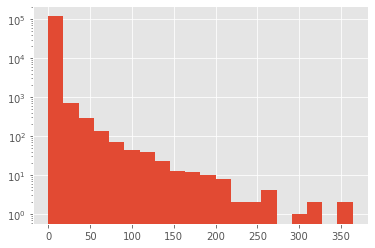

In [53]:
median_n_plot(cmnt_unigram_counts)

median:  0.6460322146349622


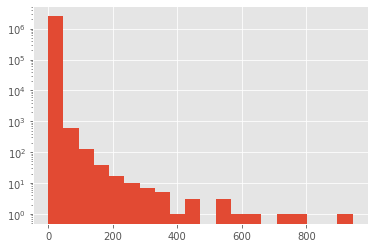

In [54]:
median_n_plot(cmnt_digram_counts)

median:  0.1221678026281239


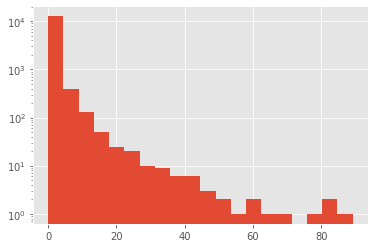

In [55]:
median_n_plot(title_unigram_counts)

median:  0.22677149775465677


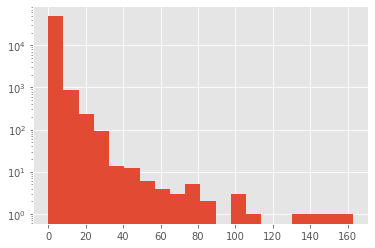

In [56]:
median_n_plot(title_digram_counts)

In [57]:
cmnt_tetragram_counts[:20]

,ngram,counts,multiplier
0,np reddit message compose,430,413.616021
1,message compose remindmebot subject,340,327.045226
2,reddit message compose remindmebot,340,327.045226
3,reddit user wikipedia_text_bot comments,233,224.122170
4,arxiv org search searchtype,196,188.531954
5,org search searchtype author,196,188.531954
6,search searchtype author query,196,188.531954
7,restrict_sr sort feature legacy_search,184,176.989181
8,5d 0a 0aremindme 21,170,163.522613
9,remindmebot subject reminder message,170,163.522613


In [58]:
title_tetragram_counts[:20]

,ngram,counts,multiplier
0,timnit gebru google megathread,2301,108.306027
1,hundreds google employees unionize,1075,50.599296
2,google employees unionize culminating,1075,50.599296
3,employees unionize culminating activism,1075,50.599296
4,nvidia geforce rtx 3060,936,44.056689
5,ai researcher timnit gebru,902,42.456339
6,ethical ai researcher timnit,902,42.456339
7,hardware unboxed review samples,755,35.537180
8,sending hardware unboxed review,755,35.537180
9,review samples focus rasterization,755,35.537180


In [59]:
ngrams = pd.concat([
    cmnt_unigram_counts, cmnt_digram_counts, 
    cmnt_trigram_counts, cmnt_tetragram_counts,
    title_unigram_counts, title_digram_counts, 
    title_trigram_counts, title_tetragram_counts
])
ngrams.sort_values('multiplier', ascending=False, inplace=True)
ngrams['n'] = ngrams.ngram.apply(lambda x: len(x.split()))
ngrams.index = range(ngrams.shape[0])
ngrams.head(30)

,ngram,counts,multiplier,n
0,wikipedia org wiki,1162,1088.469340,3
1,open source,1460,943.207033,2
2,org wiki,1204,777.822786,2
3,wikipedia org,1165,752.627530,2
4,youtube watch,951,614.376636,2
5,np reddit,921,594.995670,2
6,arxiv org,848,547.835318,2
7,cyber security,847,547.189286,2
8,machine learning,833,538.144835,2
9,long term,725,468.373356,2


In [60]:
# remove bot/moderator comments
ngrams_to_remove = '''compose|reddit message'''
ngrams = ngrams[ngrams.ngram.str.contains(ngrams_to_remove, regex=True) == False]

In [61]:
ngrams.head(30)

,ngram,counts,multiplier,n
0,wikipedia org wiki,1162,1088.469340,3
1,open source,1460,943.207033,2
2,org wiki,1204,777.822786,2
3,wikipedia org,1165,752.627530,2
4,youtube watch,951,614.376636,2
5,np reddit,921,594.995670,2
6,arxiv org,848,547.835318,2
7,cyber security,847,547.189286,2
8,machine learning,833,538.144835,2
9,long term,725,468.373356,2


In [62]:
ngrams.to_csv(f'{OUT_DIR}/cmnt_title_ngrams.csv', index=False)

In [63]:
def find_best_match(txt, terms):
    txt = set(txt.split())
    for term in terms:
        if term is None or term == '':
            continue
        term_set = set(term.split())
        if term_set.intersection(txt) == term_set:
            return term
    return 'No Match Found'

In [64]:
def text_to_ngram_reduced(df, field):
    KS = [500, 200, 150, 100, 50]
    for k in KS:
        print(f'k: {k}')
        ngrams_reduced = ngrams.loc[:k, :]
        ngrams_reduced.sort_values(
            ['n', 'multiplier'], ascending=[False, False], inplace=True)
        df[f'reduced_{k}'] = df[field].apply(
            lambda x: find_best_match(x, ngrams_reduced.ngram))

In [65]:
text_to_ngram_reduced(comment_counts, 'comment')

k: 500


<ipython-input-64-18e516d4d18a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngrams_reduced.sort_values(


k: 200
k: 150
k: 100
k: 50


In [66]:
text_to_ngram_reduced(title_counts, 'title')

k: 500


<ipython-input-64-18e516d4d18a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngrams_reduced.sort_values(


k: 200
k: 150
k: 100
k: 50


In [67]:
comment_counts.head()

,counts,comment,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50
0,1,undergraduate cybersec train included required...,write,No Match Found,No Match Found,No Match Found,No Match Found
1,1,meant prettier dunno thinking prettify tweak d...,4 4,4,4,4,No Match Found
2,1,recall note december light relax holiday secur...,security,security,security,security,security
3,1,fucking biden,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
4,1,meaningful add assuming snmp write access enab...,solve problems,access,access,No Match Found,No Match Found


In [68]:
comment_counts.tail()

,counts,comment,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50
212024,1,core counts,core,No Match Found,No Match Found,No Match Found,No Match Found
212025,1,dadjokes select sarcasm jokes,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
212026,1,admittedly havent looked havent bottomed docke...,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
212027,1,deleted task relaunched click admin task sched...,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
212028,1,5 dhcp relay cluster synced appropriately conf...,5,5,5,5,No Match Found


In [69]:
title_counts.head()

,counts,title,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50
0,2301,timnit gebru google megathread,timnit gebru google megathread,timnit gebru,google,google,No Match Found
1,1075,hundreds google employees unionize culminating...,google,google,google,google,No Match Found
2,755,nvidia longer sending hardware unboxed review ...,hardware unboxed,hardware,hardware,No Match Found,No Match Found
3,674,ltt review macbooks,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
4,671,,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found


In [70]:
title_counts.tail()

,counts,title,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50
13197,1,azure file sync s3 storage,file,No Match Found,No Match Found,No Match Found,No Match Found
13198,1,fear deployment factor,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
13199,1,aws tutorial covers aspects development devops,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
13200,1,troubleshooting firewall pat pool exhaustion c...,server,server,server,server,server
13201,1,online seminar series data driven methods scie...,data science,data science,data science,data,data


In [71]:
comment_counts.to_csv(
    '../output/commentsByNGramFreq.csv', index=False)

In [72]:
title_counts.to_csv(
    '../output/titlesByNGramFreq.csv', index=False)

In [73]:
def map_text(df, field):
    text_mapper = {}
    KS = [500, 200, 150, 100, 50]
    reduced = [f'reduced_{k}' for k in KS]
    for _, row in df.iterrows():
        text_map = {k: row[k] for k in reduced}
        text_mapper[row[field]] = text_map
    return text_mapper

In [74]:
comment_mapper = map_text(comment_counts, 'comment')

In [75]:
title_mapper = map_text(title_counts, 'title')

In [76]:
# comment_mapper

In [77]:
comment_mapper['''suppose auto failover backup server knowing stuff dhcp dns automatically shift server primary offline''']

{'reduced_500': 'dns server',
 'reduced_200': 'server',
 'reduced_150': 'server',
 'reduced_100': 'server',
 'reduced_50': 'server'}

In [78]:
# title_mapper

In [79]:
title_mapper['machine learning applied computational politics analysis conflict']

{'reduced_500': 'machine learning',
 'reduced_200': 'machine learning',
 'reduced_150': 'machine learning',
 'reduced_100': 'machine learning',
 'reduced_50': 'machine learning'}

In [80]:
with open('../output/commentMapper.json', 'w') as f:
    json.dump(comment_mapper, f)

In [81]:
with open('../output/titleMapper.json', 'w') as f:
    json.dump(title_mapper, f)